In [1]:
%load_ext nbextension
from datetime import datetime

import numpy as np
import pandas as pd
import xarray as xr
import dask
import dask.array as da
import dask.dataframe as dd

from gswp import etl
from gswp.typing import Array
from gswp.constants import GMGSI, PROBSEVERE, MRMS_BOUNDS

MRMS_BOUNDS

(-130, -60, 20, 55)

In [72]:
def constrain_bounds(
    ds: xr.Dataset, w: float, e: float, s: float, n: float, inplace=False
):
    with dask.config.set(**{"array.slicing.split_large_chunks": True}):
        lat, lon = ds.lat, ds.lon
        indexers = {
            "lat": lat[(lat > s) & (lat < n)],
            "lon": lon[(lon > w) & (lon < e)],
        }
        return ds.sel(indexers)


def index_hourly(time: np.ndarray | xr.DataArray):
    _, index = np.unique(time.astype("datetime64[h]"), return_index=True)
    return index


def constrain_time(ds: xr.Dataset, time_slice: slice):
    with dask.config.set(**{"array.slicing.split_large_chunks": True}):
        ds = ds.sel(time=time_slice)
        return ds.get({"time": index_hourly(ds["time"])})


# filtering all non CONUS values
GMGSI_DATA = constrain_bounds(GMGSI.load(), *MRMS_BOUNDS)
PS_DATA = PROBSEVERE.load()

# filtering the times the data
# constraining the upper and lower time limits
# and only times avaliable at the top of the hour
starting = max(GMGSI_DATA["time"].min(), PS_DATA["time"].min())
ending = min(GMGSI_DATA["time"].max(), PS_DATA["time"].max())
PS_DATA = constrain_time(PROBSEVERE.load(), slice(starting, ending))
GMGSI_DATA = constrain_time(GMGSI_DATA, slice(starting, ending))


print(
    f"""
{np.unique(PS_DATA.time).shape=}
{np.unique(GMGSI_DATA.time).shape=}
"""
)
GMGSI_DATA


np.unique(PS_DATA.time).shape=(5058,)
np.unique(GMGSI_DATA.time).shape=(5023,)



<xarray.Dataset>
Dimensions:    (lat: 635, lon: 972, time: 5023)
Coordinates:
  * lat        (lat) float32 20.03 20.1 20.16 20.23 ... 54.86 54.9 54.94 54.98
  * lon        (lon) float32 -130.0 -129.9 -129.8 ... -60.18 -60.11 -60.03
  * time       (time) datetime64[ns] 2022-03-04 ... 2022-09-30T23:00:00
Data variables:
    GMGSI_LW   (time, lat, lon) float32 dask.array<chunksize=(1, 635, 972), meta=np.ndarray>
    GMGSI_WV   (time, lat, lon) float32 dask.array<chunksize=(1, 635, 972), meta=np.ndarray>
    GMGSI_VIS  (time, lat, lon) float32 dask.array<chunksize=(1, 635, 972), meta=np.ndarray>
Attributes:
    Conventions:          CF-1.4
    NCO:                  netCDF Operators version 4.7.5 (Homepage = http://n...
    Satellite Sensor:     DERIVED DATA
    Source:               McIDAS Area File
    history:              Fri Sep 30 00:38:28 2022: ncks -d xc,0,4998 tempo.n...
    instrument_name:      GLOBCOMPLIR
    time_coverage_start:  2022-09-30T00:00:00

times are still not fully fit

In [85]:
ps_time = PS_DATA["time"].astype("datetime64[h]")
gmgsi_time = GMGSI_DATA["time"].astype("datetime64[h]")

gmgsi_mask = np.isin(gmgsi_time, ps_time)
ps_mask = np.isin(ps_time, gmgsi_time[gmgsi_mask])
print(
    f"""
{ps_time[ps_mask].shape=}
{gmgsi_time[gmgsi_mask].shape=}
"""
)
# merge the two datasets
merged = PS_DATA.sel({"time": ps_mask}).merge(GMGSI_DATA.sel({"time": gmgsi_mask}))
# sync the times across both datasets
merged = merged.assign_coords(
    time=merged["time"].astype("datetime64[h]")
).drop_duplicates("time")


print(
    f"""
{merged["time"].shape=}
"""
)

merged


ps_time[ps_mask].shape=(5017,)
gmgsi_time[gmgsi_mask].shape=(5017,)


merged["time"].shape=(5017,)



<xarray.Dataset>
Dimensions:            (time: 5017, lat: 635, lon: 972)
Coordinates:
  * time               (time) datetime64[ns] 2022-03-04 ... 2022-09-30T22:00:00
  * lat                (lat) float32 20.03 20.1 20.16 20.23 ... 54.9 54.94 54.98
  * lon                (lon) float32 -130.0 -129.9 -129.8 ... -60.11 -60.03
Data variables: (12/31)
    CAPE_M10M30        (time) float64 dask.array<chunksize=(12,), meta=np.ndarray>
    EBSHEAR            (time) float32 dask.array<chunksize=(12,), meta=np.ndarray>
    FLASH_DENSITY      (time) float32 dask.array<chunksize=(12,), meta=np.ndarray>
    FLASH_RATE         (time) float64 dask.array<chunksize=(12,), meta=np.ndarray>
    ID                 (time) float64 dask.array<chunksize=(12,), meta=np.ndarray>
    LJA                (time) float32 dask.array<chunksize=(12,), meta=np.ndarray>
    ...                 ...
    miny               (time) float32 dask.array<chunksize=(12,), meta=np.ndarray>
    x                  (time) float32 dask.array<chunksize=(12,), meta=np.ndarray>
    y                  (time) float32 dask.array<chunksize=(12,), meta=np.ndarray>
    GMGSI_LW           (time, lat, lon) float32 dask.array<chunksize=(1, 635, 972), meta=np.ndarray>
    GMGSI_WV           (time, lat, lon) float32 dask.array<chunksize=(1, 635, 972), meta=np.ndarray>
    GMGSI_VIS          (time, lat, lon) float32 dask.array<chunksize=(1, 635, 972), meta=np.ndarray>

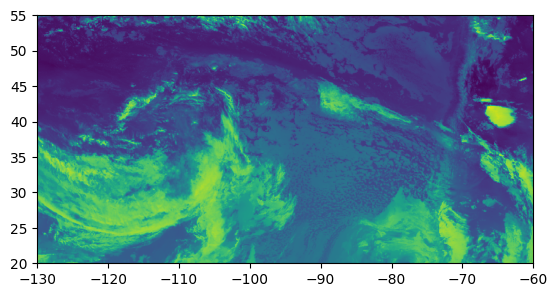

In [89]:
import matplotlib.pyplot as plt

merged.sel(time=merged.time[0])
plt.imshow(merged["GMGSI_LW"].sel(time=merged.time[0]), extent=MRMS_BOUNDS)

In [106]:
ds = merged.loc[{"time": merged["PS"] > 90}]
ds
# ds["GMGSI_LW"]

<xarray.Dataset>
Dimensions:            (time: 0, lat: 635, lon: 972)
Coordinates:
  * time               (time) datetime64[ns] 
  * lat                (lat) float32 20.03 20.1 20.16 20.23 ... 54.9 54.94 54.98
  * lon                (lon) float32 -130.0 -129.9 -129.8 ... -60.11 -60.03
Data variables: (12/31)
    CAPE_M10M30        (time) float64 dask.array<chunksize=(0,), meta=np.ndarray>
    EBSHEAR            (time) float32 dask.array<chunksize=(0,), meta=np.ndarray>
    FLASH_DENSITY      (time) float32 dask.array<chunksize=(0,), meta=np.ndarray>
    FLASH_RATE         (time) float64 dask.array<chunksize=(0,), meta=np.ndarray>
    ID                 (time) float64 dask.array<chunksize=(0,), meta=np.ndarray>
    LJA                (time) float32 dask.array<chunksize=(0,), meta=np.ndarray>
    ...                 ...
    miny               (time) float32 dask.array<chunksize=(0,), meta=np.ndarray>
    x                  (time) float32 dask.array<chunksize=(0,), meta=np.ndarray>
    y                  (time) float32 dask.array<chunksize=(0,), meta=np.ndarray>
    GMGSI_LW           (time, lat, lon) float32 dask.array<chunksize=(0, 635, 972), meta=np.ndarray>
    GMGSI_WV           (time, lat, lon) float32 dask.array<chunksize=(0, 635, 972), meta=np.ndarray>
    GMGSI_VIS          (time, lat, lon) float32 dask.array<chunksize=(0, 635, 972), meta=np.ndarray>

In [107]:
ds.x

<xarray.DataArray 'x' (time: 0)>
dask.array<getitem, shape=(0,), dtype=float32, chunksize=(0,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns]

In [105]:
from typing import NewType

dim_1 = NewType("dim[1]", tuple)
dim_2 = NewType("dim[2]", tuple)


def minimum_diffrence(
    target: np.ndarray[dim_1, np.floating], values: np.ndarray[dim_1, np.floating]
) -> da.Array:
    diff = abs(da.array(target[:, np.newaxis]) - da.array(values))
    index = da.argmin(diff, axis=0)
    return index


lat, lon = (da.array(ds[crd]) for crd in ("lat", "lon"))
# arr
ds
arr = da.array(
    [
        minimum_diffrence(lon, ds["minx"]),
        minimum_diffrence(lon, ds["maxx"]),
        minimum_diffrence(lat, ds["miny"]),
        minimum_diffrence(lat, ds["maxy"]),
    ]
).T  # .compute()
minimum_diffrence(lat, ds["minx"]).compute()
# arr.compute()
# x1, y1, y1, y2 = arr
# a = ds["GMGSI_LW"].compute()  # [595:600, 136:140].compute()
# a

array([], dtype=int64)

In [46]:
np.any(~np.isnan(a))

<xarray.DataArray 'GMGSI_LW' ()>
array(False)

In [219]:
from typing import NewType

dim_1 = NewType("dim[1]", tuple)
dim_2 = NewType("dim[2]", tuple)


def minimum_diffrence(
    target: np.ndarray[dim_1, np.floating], values: np.ndarray[dim_1, np.floating]
) -> da.Array:
    diff = abs(da.array(target[:, np.newaxis]) - da.array(values))
    index = da.argmin(diff, axis=0)
    return index


lat, lon = (da.array(metsat[crd]) for crd in ("lat", "lon"))
# creating a index
arr = da.array(
    [
        minimum_diffrence(lon, PS_DATA["minx"]),
        minimum_diffrence(lon, PS_DATA["maxx"]),
        minimum_diffrence(lat, PS_DATA["miny"]),
        minimum_diffrence(lat, PS_DATA["maxy"]),
    ]
).T
# [x1 for x1, x2, y1, y2 in arr]
# arr#.compute()

KeyboardInterrupt: 

In [68]:
ref_times = GMGSI_DATA["time"].to_numpy()
ref_times

PS_DATA["time"].to_numpy().astype("datetime64[h]")  # $.loc[ref_times]
PS_DATA["time"].to_numpy().astype("datetime64[m]") == PS_DATA["time"].to_numpy()
PS_DATA.sel(
    time=PS_DATA["time"].to_numpy().astype("datetime64[m]").astype("datetime64[s]")
    == PS_DATA["time"].to_numpy().astype("datetime64[s]")
)

<xarray.Dataset>
Dimensions:            (time: 0)
Coordinates:
  * time               (time) datetime64[ns] 
Data variables: (12/28)
    CAPE_M10M30        (time) uint32 dask.array<chunksize=(0,), meta=np.ndarray>
    EBSHEAR            (time) float32 dask.array<chunksize=(0,), meta=np.ndarray>
    FLASH_DENSITY      (time) float32 dask.array<chunksize=(0,), meta=np.ndarray>
    FLASH_RATE         (time) uint32 dask.array<chunksize=(0,), meta=np.ndarray>
    ID                 (time) uint32 dask.array<chunksize=(0,), meta=np.ndarray>
    LJA                (time) float32 dask.array<chunksize=(0,), meta=np.ndarray>
    ...                 ...
    maxx               (time) float32 dask.array<chunksize=(0,), meta=np.ndarray>
    maxy               (time) float32 dask.array<chunksize=(0,), meta=np.ndarray>
    minx               (time) float32 dask.array<chunksize=(0,), meta=np.ndarray>
    miny               (time) float32 dask.array<chunksize=(0,), meta=np.ndarray>
    x                  (time) float32 dask.array<chunksize=(0,), meta=np.ndarray>
    y                  (time) float32 dask.array<chunksize=(0,), meta=np.ndarray>

In [107]:
# a = np.unique(PS_DATA.time.astype("datetime64[h]"))
from datetime import timedelta


a = abs(
    PS_DATA["time"].to_numpy().astype("datetime64[h]")
    - PS_DATA["time"].to_numpy().astype("datetime64[s]")
)

x = a < timedelta(seconds=60)
a = PS_DATA.sel(time=x)
ps_hours = np.unique(a.time).astype("datetime64[h]")
print(len(ps_hours))
ps_hours

5012


array(['2022-03-04T00', '2022-03-04T01', '2022-03-04T02', ...,
       '2022-09-30T20', '2022-09-30T21', '2022-09-30T22'],
      dtype='datetime64[h]')

In [128]:
_, index = np.unique(PS_DATA["time"].astype("datetime64[h]"), return_index=True)

PS_DATA.get(dict(time=index))

<xarray.Dataset>
Dimensions:            (time: 5016)
Coordinates:
  * time               (time) datetime64[ns] 2022-03-04T00:00:37 ... 2022-09-...
Data variables: (12/28)
    CAPE_M10M30        (time) uint32 dask.array<chunksize=(11,), meta=np.ndarray>
    EBSHEAR            (time) float32 dask.array<chunksize=(11,), meta=np.ndarray>
    FLASH_DENSITY      (time) float32 dask.array<chunksize=(11,), meta=np.ndarray>
    FLASH_RATE         (time) uint32 dask.array<chunksize=(11,), meta=np.ndarray>
    ID                 (time) uint32 dask.array<chunksize=(11,), meta=np.ndarray>
    LJA                (time) float32 dask.array<chunksize=(11,), meta=np.ndarray>
    ...                 ...
    maxx               (time) float32 dask.array<chunksize=(11,), meta=np.ndarray>
    maxy               (time) float32 dask.array<chunksize=(11,), meta=np.ndarray>
    minx               (time) float32 dask.array<chunksize=(11,), meta=np.ndarray>
    miny               (time) float32 dask.array<chunksize=(11,), meta=np.ndarray>
    x                  (time) float32 dask.array<chunksize=(11,), meta=np.ndarray>
    y                  (time) float32 dask.array<chunksize=(11,), meta=np.ndarray>

In [113]:
diff = abs(
    GMGSI_DATA["time"].to_numpy().astype("datetime64[s]")[:, np.newaxis]
    - ps_hours.astype("datetime64[s]")
)
sat = GMGSI_DATA.get(
    dict(
        # time=ps_hours.astype("datetime64[s]")
        time=np.unique(np.argmin(diff, axis=0))
    )
)
print(
    f"""
{len(np.unique(ps_hours))}
{len(np.unique(sat.time))}
"""
)


5012
4971



In [5]:
print(
    f"""
{len(np.unique(PS_DATA["time"].astype("datetime64[m]")))=}
{len(GMGSI_DATA["time"])=}"""
)
arr = np.any(
    GMGSI_DATA["time"].to_numpy()[:, np.newaxis].astype("datetime64[m]")
    == PS_DATA["time"].to_numpy().astype("datetime64[m]"),
    axis=1,
)
# arr.time


# len(arr)
# gmgsi = GMGSI_DATA.sel(time=arr)


len(np.unique(PS_DATA["time"].astype("datetime64[m]")))=5019
len(GMGSI_DATA["time"])=5053


AttributeError: 'numpy.ndarray' object has no attribute 'time'

In [37]:
time_diff = GMGSI_DATA["time"].to_numpy()[:, np.newaxis].astype(
    "datetime64[m]"
) == PS_DATA["time"].to_numpy().astype("datetime64[m]")

In [27]:
a = PROBSEVERE.load()
b = GMGSI.load()

In [1]:
from datetime import timedelta

b.time.to_numpy()[:, np.newaxis]

NameError: name 'b' is not defined

In [59]:
df: dd.DataFrame = PS_DATA.to_dask_dataframe()
# df = df.loc[df.time.dt.minute > 2, :]
# df

In [70]:
# len(df), len(df1)
# xr.open_zarr(PROBSEVERE.STORE)
PPS_DATA = PS_DATA.sel(time=PS_DATA.time.dt.minute < 2)
# PS_DATA.sel({"time": pd.to_datetime(PS_DATA.time).minute > 2})

In [ ]:
xr.open_zarr(PROBSEVERE.STORE)

In [3]:
from gswp.constants import MRMS_BOUNDS
import xarray as xr
import dask
import numpy as np
from typing import NewType

dim_1 = NewType("dim[1]", tuple)
dim_2 = NewType("dim[2]", tuple)


def constrain_bounds(
    ds: xr.Dataset, w: float, e: float, s: float, n: float, inplace=False
):
    lat, lon = ds.lat, ds.lon
    lat = lat[(lat > s) & (lat < n)]
    lon = lon[(lon > w) & (lon < e)]
    with dask.config.set(**{"array.slicing.split_large_chunks": True}):
        return ds.sel({"lat": lat, "lon": lon})


def min_diff(
    target: np.ndarray[dim_1, np.floating], values: np.ndarray[dim_1, np.floating]
) -> np.ndarray[dim_1, np.unsignedinteger]:
    diff = abs(target[:, np.newaxis] - values)
    index = np.argmin(diff, axis=0)
    return index


gmgsi = constrain_bounds(SAT_DATA, -130, -60, 20, 55)
gmgsi

<xarray.Dataset>
Dimensions:    (lat: 635, lon: 972, time: 5053)
Coordinates:
  * lat        (lat) float32 20.03 20.1 20.16 20.23 ... 54.86 54.9 54.94 54.98
  * lon        (lon) float32 -130.0 -129.9 -129.8 ... -60.18 -60.11 -60.03
  * time       (time) datetime64[ns] 2022-03-04 ... 2022-09-30T23:00:00
Data variables:
    GMGSI_LW   (time, lat, lon) float32 dask.array<chunksize=(1, 635, 972), meta=np.ndarray>
    GMGSI_WV   (time, lat, lon) float32 dask.array<chunksize=(1, 635, 972), meta=np.ndarray>
    GMGSI_VIS  (time, lat, lon) float32 dask.array<chunksize=(1, 635, 4), meta=np.ndarray>
Attributes:
    Conventions:          CF-1.4
    NCO:                  netCDF Operators version 4.7.5 (Homepage = http://n...
    Satellite Sensor:     DERIVED DATA
    Source:               McIDAS Area File
    history:              Fri Sep 30 00:38:28 2022: ncks -d xc,0,4998 tempo.n...
    instrument_name:      GLOBCOMPLIR
    time_coverage_start:  2022-09-30T00:00:00

In [23]:
PS_DATA.sel(
    {
        "time": slice(
            max(SAT_DATA["time"].min(), PS_DATA["time"].min()),
            min(SAT_DATA["time"].max(), PS_DATA["time"].max()),
        )
    }
)
# SAT_DATA

<xarray.Dataset>
Dimensions:            (time: 17127421)
Coordinates:
  * time               (time) datetime64[ns] 2022-03-04T00:00:37 ... 2022-09-...
Data variables: (12/28)
    CAPE_M10M30        (time) uint32 dask.array<chunksize=(806,), meta=np.ndarray>
    EBSHEAR            (time) float32 dask.array<chunksize=(806,), meta=np.ndarray>
    FLASH_DENSITY      (time) float32 dask.array<chunksize=(806,), meta=np.ndarray>
    FLASH_RATE         (time) uint32 dask.array<chunksize=(806,), meta=np.ndarray>
    ID                 (time) uint32 dask.array<chunksize=(806,), meta=np.ndarray>
    LJA                (time) float32 dask.array<chunksize=(806,), meta=np.ndarray>
    ...                 ...
    maxx               (time) float32 dask.array<chunksize=(806,), meta=np.ndarray>
    maxy               (time) float32 dask.array<chunksize=(806,), meta=np.ndarray>
    minx               (time) float32 dask.array<chunksize=(806,), meta=np.ndarray>
    miny               (time) float32 dask.array<chunksize=(806,), meta=np.ndarray>
    x                  (time) float32 dask.array<chunksize=(806,), meta=np.ndarray>
    y                  (time) float32 dask.array<chunksize=(806,), meta=np.ndarray>

In [4]:
from re import A
import dask.array as da


def dask_min_diff(
    target: np.ndarray[dim_1, np.floating], values: np.ndarray[dim_1, np.floating]
) -> da.Array:
    diff = abs(da.array(target[:, np.newaxis]) - da.array(values))
    index = da.argmin(diff, axis=0)
    return index  # .astype(int)


lat, lon = (da.array(gmgsi[crd]) for crd in ("lat", "lon"))

arr = da.array(
    [
        dask_min_diff(lon, PS_DATA["minx"]),
        dask_min_diff(lon, PS_DATA["maxx"]),
        dask_min_diff(lat, PS_DATA["miny"]),
        dask_min_diff(lat, PS_DATA["maxy"]),
    ]
).T
x1, x2, y1, y2 = arr[6000].compute()
x1, x2, y1, y2

(575, 576, 156, 157)

In [6]:
# SAT_DATA.merge(PS_DATA)
# da.array(gmgsi["GMGSI_LW"])[...,x1:x2, y1:y2].compute()
# arr = da.array(
#     [
#         gmgsi["GMGSI_LW"],  # .to_numpy(),
#         gmgsi["GMGSI_VIS"],  # to_numpy(),
#         gmgsi["GMGSI_WV"],  # .to_numpy(),
#     ]
# )
# gmgsi.to_array()
# da.array(lon).compute()

In [117]:
PS_DATA["minx"].compute(), lon

(<xarray.DataArray 'minx' (time: 17139030)>
 array([-79.21, -80.32, -80.95, ..., -74.49, -75.38, -74.3 ], dtype=float32)
 Coordinates:
   * time     (time) datetime64[ns] 2022-03-01T00:00:29 ... 2022-09-30T23:58:41,
 dask.array<array, shape=(1111,), dtype=float32, chunksize=(1111,), chunktype=numpy.ndarray>)

In [53]:
import xarray as xr
from gswp.constants import MRMS_BOUNDS
from typing import TypeVar

T = TypeVar("T")


class Base:
    def __init__(self, data: xr.Dataset) -> None:
        self._data = data

    def to_xarray(self):
        return self._data

    def __repr__(self) -> str:
        return repr(self.to_xarray())

    def _repr_html_(self):
        return self.to_xarray()._repr_html_()

    # def __getattribute__(self: T, __name: str) -> xr.DataArray:
    #     try:
    #         return super().__getattribute__(__name)
    #     except AttributeError:
    #         print(__name)
    #         return self._data[__name]


class ProbSevere(Base):
    _data = PS_DATA

    def fit(self):
        ...


class Metsat(Base):
    _data = SAT_DATA

    @property
    def latitudes(self):
        return self.to_xarray()["lat"].to_numpy()

    @property
    def longitude(self):
        return self.to_xarray()["lon"].to_numpy()

    def constrain_bounds(self, w: float, e: float, s: float, n: float, inplace=False):
        lat, lon = self.latitudes, self.longitude
        lat = lat[(lat > s) & (lat < n)]
        lon = lon[(lon > w) & (lon < e)]
        result = self.to_xarray().sel({"lat": lat, "lon": lon})
        if inplace:
            self._data = result
            return self
        else:
            return Metsat(result)


ps = ProbSevere(PS_DATA)
sat = Metsat(SAT_DATA).constrain_bounds(*MRMS_BOUNDS)

sat

/opt/venv/lib/python3.10/site-packages/xarray/core/indexing.py:1380: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


<xarray.Dataset>
Dimensions:    (lat: 2419, lon: 1111, time: 5053)
Coordinates:
  * lat        (lat) float32 -72.74 -72.72 -72.69 -72.67 ... 54.9 54.94 54.98
  * lon        (lon) float32 -59.96 -59.89 -59.82 -59.75 ... 19.82 19.9 19.97
  * time       (time) datetime64[ns] 2022-03-04 ... 2022-09-30T23:00:00
Data variables:
    GMGSI_LW   (time, lat, lon) float32 dask.array<chunksize=(1, 2419, 1111), meta=np.ndarray>
    GMGSI_WV   (time, lat, lon) float32 dask.array<chunksize=(1, 2419, 1111), meta=np.ndarray>
    GMGSI_VIS  (time, lat, lon) float32 dask.array<chunksize=(1, 2419, 1111), meta=np.ndarray>
Attributes:
    Conventions:          CF-1.4
    NCO:                  netCDF Operators version 4.7.5 (Homepage = http://n...
    Satellite Sensor:     DERIVED DATA
    Source:               McIDAS Area File
    history:              Fri Sep 30 00:38:28 2022: ncks -d xc,0,4998 tempo.n...
    instrument_name:      GLOBCOMPLIR
    time_coverage_start:  2022-09-30T00:00:00